In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as pp
import pylab
import scipy
import pandas as pd
from scipy.optimize import curve_fit
import pickle

%matplotlib inline

# import model and curvefit functions
# from models_functions import mf_noseg
# from fit_functions import fit_mf_noseg

# list of files
list_of_files=['hoaxy_4th-mysterious-death-connected-to-the-dnc_cum','hoaxy_alicia-machado-adult-star_cum','hoaxy_bill-clinton-illegitimate-son_cum','hoaxy_black-lives-matter-protesters-chant-for-dead-cops-now-in-baton-rouge_cum','hoaxy_black-protesters-targeted-whites-in-milwaukee_cum','hoaxy_clinton-byrd-photo-klan_cum','hoaxy_clinton-compliant-citizenry_cum','hoaxy_clinton-secret-earpiece-debate_cum','hoaxy_clintons_zeifman_cum','hoaxy_debate-secret-hand-signals_cum','hoaxy_deray-mckesson-and-the-summer-of-chaos_cum','hoaxy_dnc-hiring-actors-via-craigslist-to-replace-delegates_cum','hoaxy_dr-drew-hillary-clinton-health_cum','hoaxy_flags-banned-at-dnc_cum','hoaxy_google-manipulate-hillary-clinton_cum','hoaxy_hillary-clinton-freed-child-rapist-laughed-about-it_cum','hoaxy_hillary-clinton-has-parkinsons-disease_cum','hoaxy_hillary-clinton-medical-records-leaked_cum','hoaxy_hillary-clinton-seizure-video_cum','hoaxy_julian-assange-bernie-sanders-was-threatened_cum','hoaxy_khizr-khan-375000-clinton-foundation_cum','hoaxy_khizr-khan-is-a-muslim-brotherhood-agent_cum','hoaxy_mexico-border-trump-elected_cum','hoaxy_michael-savage-removed_cum','hoaxy_muslims-in-japan_cum','hoaxy_politics-sites-mismatched-clinton-rally-image-goes-viral_cum','hoaxy_satire_sharia_cum','hoaxy_seth-conrad-rich_cum','hoaxy_three-syrian-refugees-assault-5-year-old-girl-at-knifepoint_cum','hoaxy_tim-kaine-white-people-minority_cum','hoaxy_yokohillary_cum']
path_file = "../../data/"

# threshold for when a contagion is said to have plateaud
plateau_threshold = 48;

# Function definitions

In [3]:
def mf_noseg(T, alpha, ONEoverN, ba_init, bi_init, pv, omega):
    
    # Network size
    N=1./ONEoverN
    
    # Initial conditions
    pBI0, pBA0, pFI0, pFA0, pS0 = N*bi_init, N*ba_init, 0., 0., N*(1.-ba_init-bi_init)
    
    ba = []
    fa = []
    for i in T:
        
        ba.append(pBA0)
        fa.append(pFA0)
        
        f = pBA0/N
        pBI1 = alpha * f * pS0 + omega * pBA0 + (1. - pv) * (1 - f) * pBI0
        pBA1 = (1. - pv) * f  * pBI0 + (1. - omega) * (1. - pv) * pBA0
        pFI1 = (1-alpha) * f * pS0 + omega * pFA0 + pv * (pBI0 + (1. - omega) * pBA0) + (1 - f) * pFI0
        pFA1 = f * pFI0 + (1. - omega) * pFA0
        pS1 = (1 - f) * pS0
        
        #update
        pBI0, pBA0, pFI0, pFA0, pS0 = pBI1, pBA1, pFI1, pFA1, pS1
        
        if float(pBI0)<=0.0000000001:
            pBI0=0.0
        if float(pBA0)<=0.0000000001:
            pBA0=0.0
        if float(pFI0)<=0.0000000001:
            pFI0=0.0
        if float(pFA0)<=0.0000000001:
            pFA0=0.0
        if float(pS0)<=0.0000000001:
            pS0=0.0
    
    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))

# To return only one of the types (needed for fitting only against one type)
def mf_noseg_BA(T, alpha, ONEoverN, ba_init, bi_init, pv, omega):
    return mf_noseg(T, alpha, ONEoverN, ba_init, bi_init, pv, omega)[0]

def mf_noseg_FA(T, alpha, ONEoverN, ba_init, bi_init, pv, omega):
    return mf_noseg(T, alpha, ONEoverN, ba_init, bi_init, pv, omega)[1]


def mf_noseg_FI(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega):
    
    # Network size
    N=1./ONEoverN
    
    # Initial conditions
    pBI0, pBA0, pFI0, pFA0, pS0 = N*bi_init, N*ba_init, N*fi_init, N*fa_init, N*(1.-ba_init-bi_init-fa_init-fi_init)
    
    ba = []
    fa = []
    for i in T:
        
        ba.append(pBA0)
        fa.append(pFA0)
        
        f = pBA0/N
        pBI1 = alpha * f * pS0 + omega * pBA0 + (1. - pv) * (1 - f) * pBI0
        pBA1 = (1. - pv) * f  * pBI0 + (1. - omega) * (1. - pv) * pBA0
        pFI1 = (1-alpha) * f * pS0 + omega * pFA0 + pv * (pBI0 + (1. - omega) * pBA0) + (1 - f) * pFI0
        pFA1 = f * pFI0 + (1. - omega) * pFA0
        pS1 = (1 - f) * pS0
        
        #update
        pBI0, pBA0, pFI0, pFA0, pS0 = pBI1, pBA1, pFI1, pFA1, pS1
        
        if float(pBI0)<=0.0000000001:
            pBI0=0.0
        if float(pBA0)<=0.0000000001:
            pBA0=0.0
        if float(pFI0)<=0.0000000001:
            pFI0=0.0
        if float(pFA0)<=0.0000000001:
            pFA0=0.0
        if float(pS0)<=0.0000000001:
            pS0=0.0
    
    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))

# To return only one of the types (needed for fitting only against one type)
def mf_noseg_FI_BA(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega):
    return mf_noseg_FI(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega)[0]

def mf_noseg_FI_FA(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega):
    return mf_noseg_FI(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega)[1]


def mf_seg(T, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, pvg, pvs, omega, gulsize, s):
    
    # Network and component sizes
    N=1./ONEoverN
    N_gullible=N*gulsize
    N_skeptic=N-N_gullible
    
    
    # Initial conditions
    # Gullible
    pBI0g, pBA0g, pFI0g, pFA0g, pS0g = N_gullible*bi_initg, N_gullible*ba_initg, 0.0, 0.0, N_gullible*(1.- (ba_initg+bi_initg))
    # Skeptical
    pBI0s, pBA0s, pFI0s, pFA0s, pS0s = N_skeptic*bi_inits, N_skeptic*ba_inits, 0.0, 0.0, N_skeptic*(1.- (ba_inits+bi_inits))
    
    ba=[]
    fa=[]
    
    for i in T:
        
        # record
        ba.append(pBA0g+pBA0s)
        fa.append(pFA0g+pFA0s)
        
        # update
        fg  = s*pBA0g/N_gullible+(1-s)*pBA0s/N_skeptic
        fs = s*pBA0s/N_skeptic+(1-s)*pBA0g/N_gullible
        
        pBI1g = alphag * fg * pS0g + omega * pBA0g + (1. - pvg) * (1. - fg) * pBI0g
        pBA1g = (1. - pvg) * fg * pBI0g + (1. - omega) * (1. - pvg) * pBA0g
        pFI1g = (1-alphag) * fg * pS0g + omega * pFA0g + pvg * (pBI0g + (1. - omega) * pBA0g) + (1 - fg) * pFI0g
        pFA1g = fg * pFI0g + (1. - omega) * pFA0g
        pS1g = (1. - fg) * pS0g
        
        pBI1s = alphas * fs * pS0s + omega * pBA0s + (1. - pvs) * (1. - fs) * pBI0s
        pBA1s = (1. - pvs) * fs * pBI0s + (1. - omega) * (1. - pvs) * pBA0s
        pFI1s = (1-alphas) * fs * pS0s + omega * pFA0s + pvs * (pBI0s + (1. - omega) * pBA0s) + (1 - fs) * pFI0s
        pFA1s = fs * pFI0s + (1. - omega) * pFA0s
        pS1s = (1. - fs) * pS0s
        
        pBI0g, pBA0g, pFI0g, pFA0g, pS0g = pBI1g, pBA1g, pFI1g, pFA1g, pS1g
        pBI0s, pBA0s, pFI0s, pFA0s, pS0s = pBI1s, pBA1s, pFI1s, pFA1s, pS1s
        
        if float(pBI0s)<=0.0000000001:
            pBI0s=0.0
        if float(pBA0s)<=0.0000000001:
            pBA0s=0.0
        if float(pFI0s)<=0.0000000001:
            pFI0s=0.0
        if float(pFA0s)<=0.0000000001:
            pFA0s=0.0
        if float(pS0s)<=0.0000000001:
            pS0s=0.0
        if float(pBI0g)<=0.0000000001:
            pBI0g=0.0
        if float(pBA0g)<=0.0000000001:
            pBA0g=0.0
        if float(pFI0g)<=0.0000000001:
            pFI0g=0.0
        if float(pFA0g)<=0.0000000001:
            pFA0g=0.0
        if float(pS0g)<=0.0000000001:
            pS0g=0.0
    
    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))


def mf_seg_FI(T, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits,
              fa_initg, fi_initg, fa_inits, fi_inits, pvg, pvs, omega, gulsize, s):
    
    # Network and component sizes
    N=1./ONEoverN
    N_gullible=N*gulsize
    N_skeptic=N-N_gullible
    
    
    # Initial conditions
    # Gullible
    pBI0g, pBA0g, pFI0g, pFA0g, pS0g = N_gullible*bi_initg, N_gullible*ba_initg, N_gullible*fi_initg, N_gullible*fa_initg, N_gullible*(1.- (ba_initg+bi_initg+fa_initg+fi_initg))
    # Skeptical
    pBI0s, pBA0s, pFI0s, pFA0s, pS0s = N_skeptic*bi_inits, N_skeptic*ba_inits, N_skeptic*fi_inits, N_skeptic*fa_inits, N_skeptic*(1.- (ba_inits+bi_inits+fa_inits+fi_inits))
    
    ba=[]
    fa=[]
    
    for i in T:
        
        # record
        ba.append(pBA0g+pBA0s)
        fa.append(pFA0g+pFA0s)
        
        # update
        fg  = s*pBA0g/N_gullible+(1-s)*pBA0s/N_skeptic
        fs = s*pBA0s/N_skeptic+(1-s)*pBA0g/N_gullible
        
        pBI1g = alphag * fg * pS0g + omega * pBA0g + (1. - pvg) * (1. - fg) * pBI0g
        pBA1g = (1. - pvg) * fg * pBI0g + (1. - omega) * (1. - pvg) * pBA0g
        pFI1g = (1-alphag) * fg * pS0g + omega * pFA0g + pvg * (pBI0g + (1. - omega) * pBA0g) + (1 - fg) * pFI0g
        pFA1g = fg * pFI0g + (1. - omega) * pFA0g
        pS1g = (1. - fg) * pS0g
        
        pBI1s = alphas * fs * pS0s + omega * pBA0s + (1. - pvs) * (1. - fs) * pBI0s
        pBA1s = (1. - pvs) * fs * pBI0s + (1. - omega) * (1. - pvs) * pBA0s
        pFI1s = (1-alphas) * fs * pS0s + omega * pFA0s + pvs * (pBI0s + (1. - omega) * pBA0s) + (1 - fs) * pFI0s
        pFA1s = fs * pFI0s + (1. - omega) * pFA0s
        pS1s = (1. - fs) * pS0s
        
        pBI0g, pBA0g, pFI0g, pFA0g, pS0g = pBI1g, pBA1g, pFI1g, pFA1g, pS1g
        pBI0s, pBA0s, pFI0s, pFA0s, pS0s = pBI1s, pBA1s, pFI1s, pFA1s, pS1s
        
        if float(pBI0s)<=0.0000000001:
            pBI0s=0.0
        if float(pBA0s)<=0.0000000001:
            pBA0s=0.0
        if float(pFI0s)<=0.0000000001:
            pFI0s=0.0
        if float(pFA0s)<=0.0000000001:
            pFA0s=0.0
        if float(pS0s)<=0.0000000001:
            pS0s=0.0
        if float(pBI0g)<=0.0000000001:
            pBI0g=0.0
        if float(pBA0g)<=0.0000000001:
            pBA0g=0.0
        if float(pFI0g)<=0.0000000001:
            pFI0g=0.0
        if float(pFA0g)<=0.0000000001:
            pFA0g=0.0
        if float(pS0g)<=0.0000000001:
            pS0g=0.0
    
    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))



def fit_mf_noseg(T_double, alpha, ONEoverN, ba_init, bi_init, pv, omega):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_noseg(T, alpha, ONEoverN, ba_init, bi_init, pv, omega)
    return np.append(BA, FA)

def fit_mf_noseg_FI(T_double, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_noseg_FI(T, alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega)
    return np.append(BA, FA)

def fit_mf_seg(T_double, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, pvg, pvs, omega, gulsize, s):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_seg(T, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, pvg, pvs, omega, gulsize, s)
    return np.append(BA, FA)

def fit_mf_seg_FI(T_double, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, fa_initg, fi_initg, fa_inits, fi_inits, pvg, pvs, omega, gulsize, s):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_seg_FI(T, alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, fa_initg, fi_initg, fa_inits, fi_inits, pvg, pvs, omega, gulsize, s)
    return np.append(BA, FA)

# Model fitting

For each data set
 - read and filter in the data
 - fit the non segregated model
 - plot and meaure the difference
 

# Fit using non segregated model

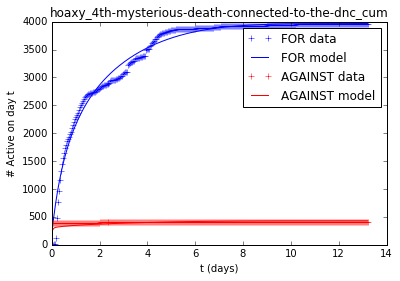

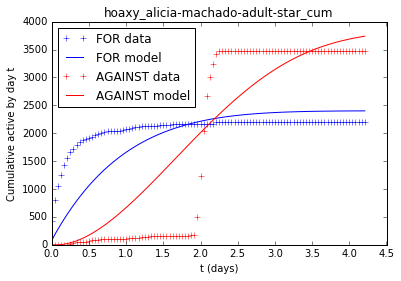

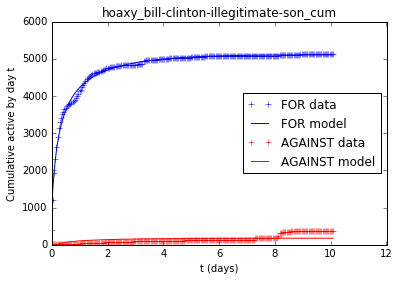

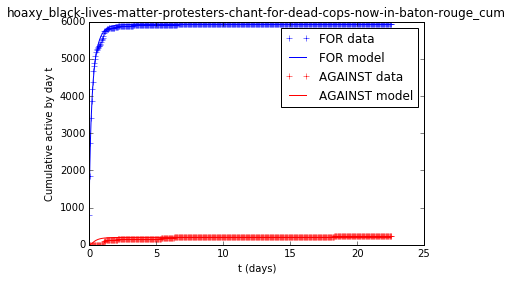

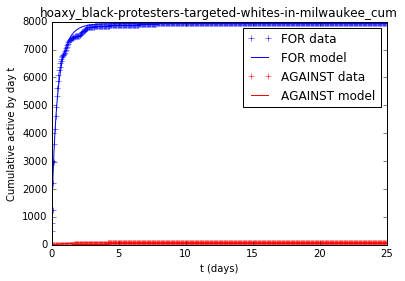

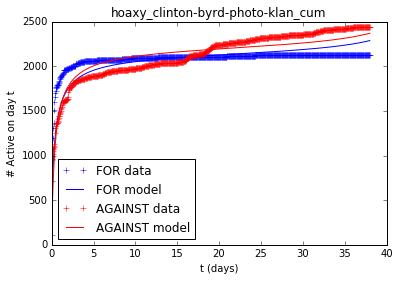

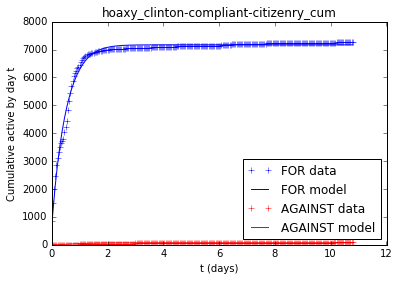

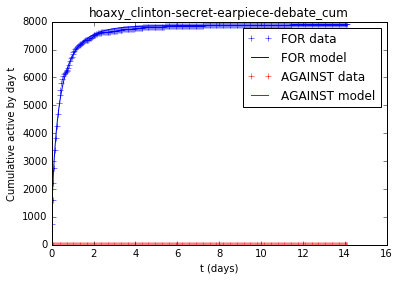

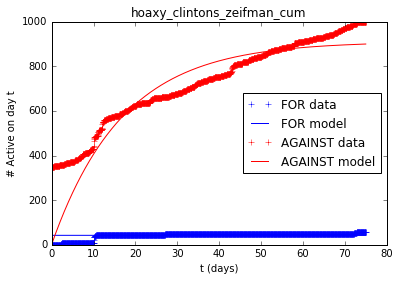

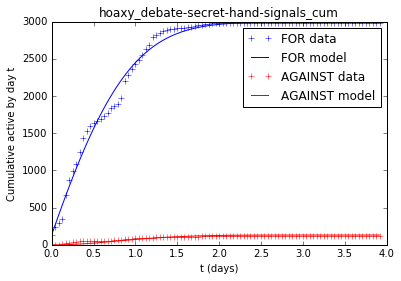

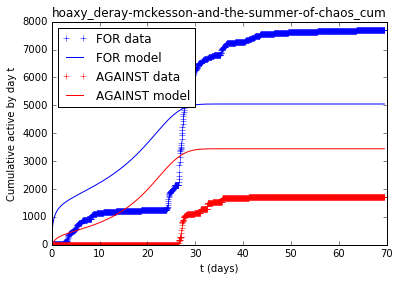

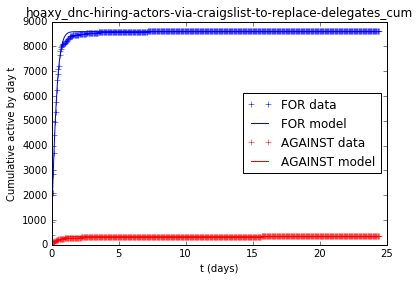

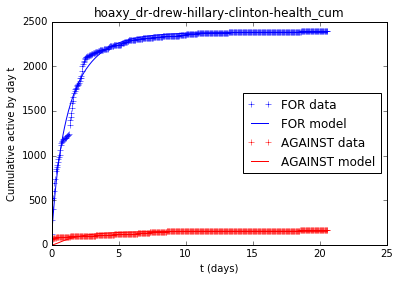

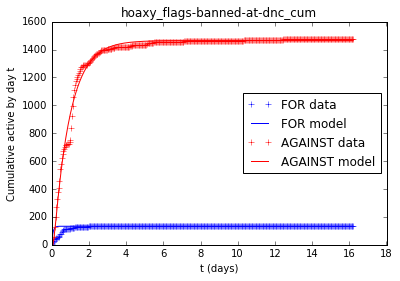

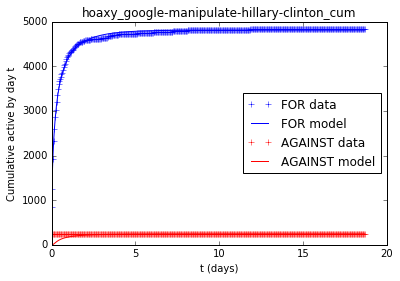

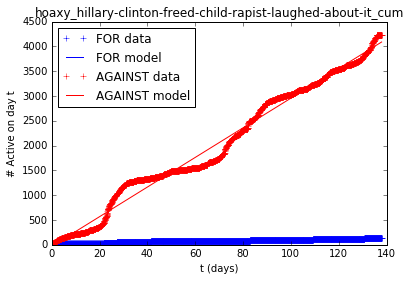

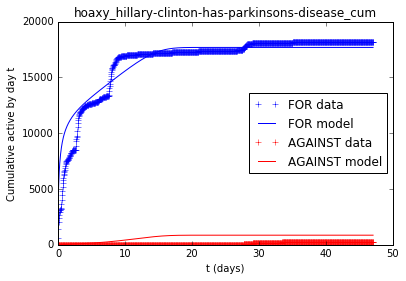

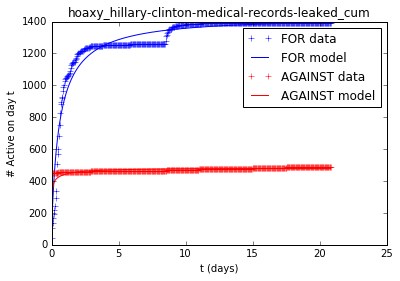

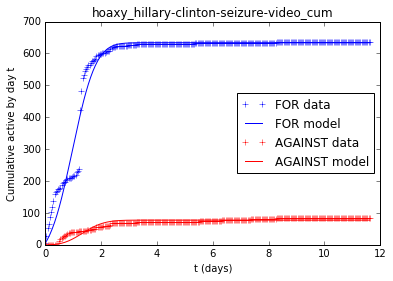

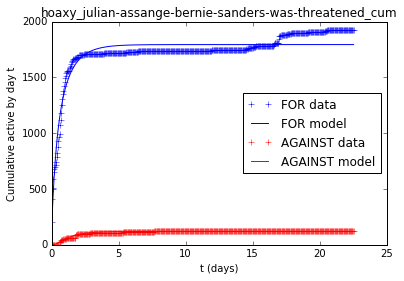

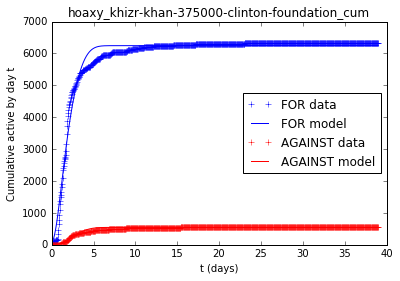

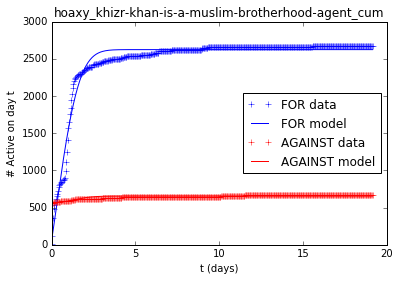

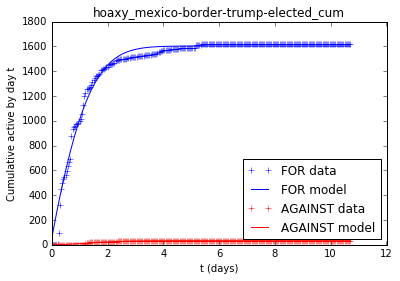

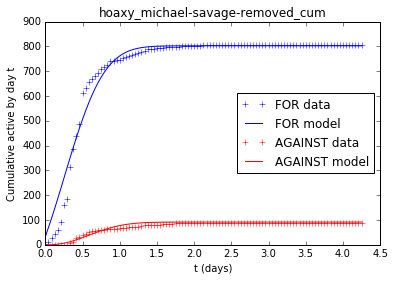

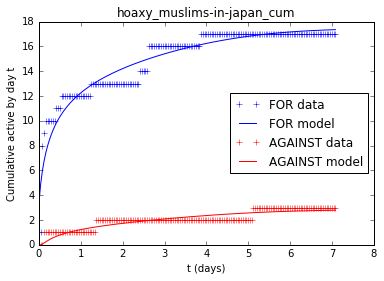

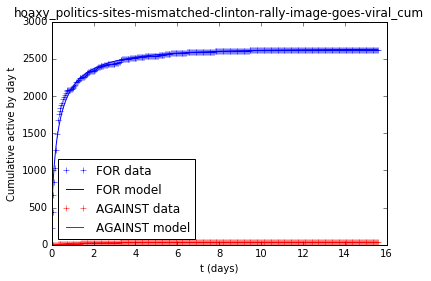

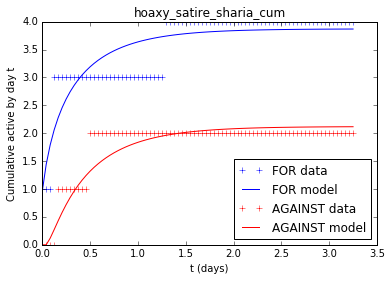

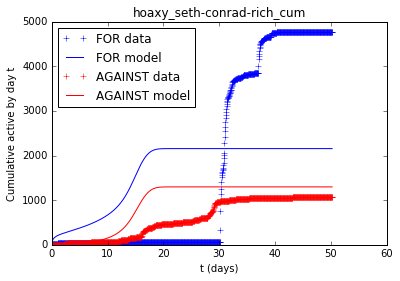

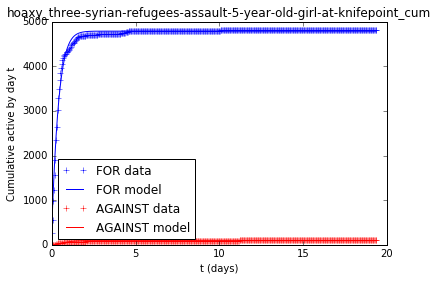

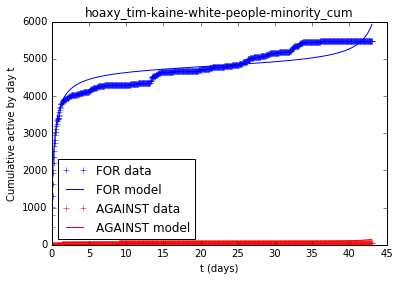

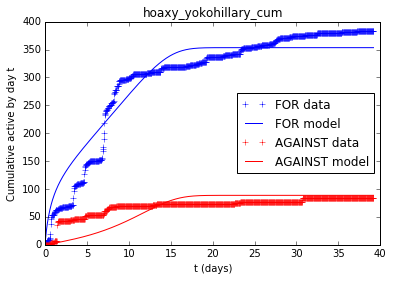

In [15]:
noseg_fit_popt = [];
noseg_fit_poptFI = [];
noseg_fit_pcov = [];
noseg_fit_pcovFI = [];
noseg_fit_RMSerror = [];
noseg_fit_NRMSerror = [];
noseg_fit_MPerror = [];

for i in np.linspace(0,len(list_of_files)-1,len(list_of_files),dtype=int):
    
    # READ DATA

    file_name = str(list_of_files[i])
    hoax_data = pd.read_csv(path_file+file_name+'.csv',parse_dates=True)
    for_users = hoax_data["For"]
    against_users = hoax_data["Against"]
    t_empirical=np.arange(0,len(for_users))

    # FILTER DATA

    # remove the initial plateau from the data
    first_nonzero = np.nonzero(for_users)[0][0]
    for_users = for_users[first_nonzero:]
    against_users = against_users[first_nonzero:]

    # find the position of the end of the dynamics (including buffer plateau at end of length plateau_threshold)
    d_for_users = np.subtract(for_users[plateau_threshold-1:],for_users[0:-plateau_threshold+1]);
    d_against_users = np.subtract(against_users[plateau_threshold-1:],against_users[0:-plateau_threshold+1]);
    plateau = np.nonzero((np.add(d_for_users,d_against_users))==0)[0];
    if (plateau.size > 0):
        temporal_window = plateau[0] + plateau_threshold
        for_users = for_users[0:temporal_window]
        against_users = against_users[0:temporal_window]

    t_empirical=np.arange(0,len(for_users))

    # CURVEFIT AND PLOT

    if against_users.values[0] > for_users.values[0]:  #Initial fraction of factchecker
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001,0.001,0.001, 0.001, 0.5,0.5
        param_bounds =([0., 0., 0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1., 1., 1.])

        # Curve fit
        T_double = np.append(t_empirical, t_empirical)
        data_double = np.append(for_users, against_users)
        popt, pcov = curve_fit(fit_mf_noseg_FI, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)

        # Save measurements
        noseg_fit_poptFI.append(popt)
        noseg_fit_pcovFI.append(pcov)
        BA, FA = mf_noseg_FI(t_empirical,*popt)
        noseg_fit_RMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double)))
        noseg_fit_NRMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double))/np.average(data_double))
        noseg_fit_MPerror.append(np.sum(np.abs(np.append(BA,FA) - data_double)/data_double)/len(data_double))
        
        # Plot
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("# Active on day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/fits/"+str(i+1)+"_noseg.pdf")
        pp.show()

    else:
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001, 0.001, 0.5,0.5
        param_bounds =([0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1.])

        # Curve fit
        T_double = np.append(t_empirical, t_empirical)
        data_double = np.append(for_users, against_users)
        popt, cov = curve_fit(fit_mf_noseg, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)

        # Save measurements
        noseg_fit_popt.append(popt)
        noseg_fit_pcov.append(pcov)
        BA, FA = mf_noseg(t_empirical,*popt)
        noseg_fit_RMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double)))
        noseg_fit_NRMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double))/np.average(data_double))
        noseg_fit_MPerror.append(np.sum(np.abs(np.append(BA,FA) - data_double)/data_double)/len(data_double))
        
        # Plot
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("Cumulative active by day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/fits/"+str(i+1)+"_noseg.pdf")
        pp.show()
    

In [16]:
# Save outputs
f = open("../../data/processed/outputs_noseg.pckl","wb")
pickle.dump([noseg_fit_popt,noseg_fit_poptFI,noseg_fit_pcov,noseg_fit_pcovFI,noseg_fit_RMSerror,noseg_fit_NRMSerror,noseg_fit_MPerror], f)
f.close()

### Analysis

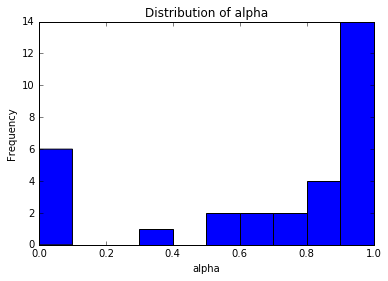

Low belief hoaxs:

['hoaxy_clinton-byrd-photo-klan_cum'
 'hoaxy_google-manipulate-hillary-clinton_cum'
 'hoaxy_hillary-clinton-freed-child-rapist-laughed-about-it_cum'
 'hoaxy_mexico-border-trump-elected_cum' 'hoaxy_satire_sharia_cum'
 'hoaxy_three-syrian-refugees-assault-5-year-old-girl-at-knifepoint_cum']


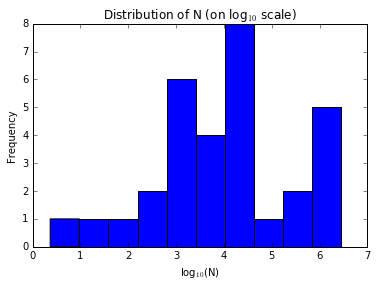

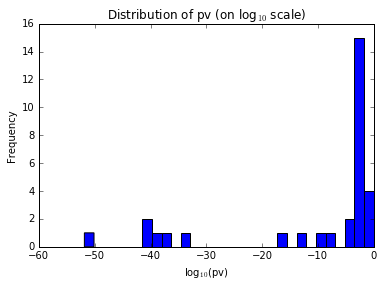

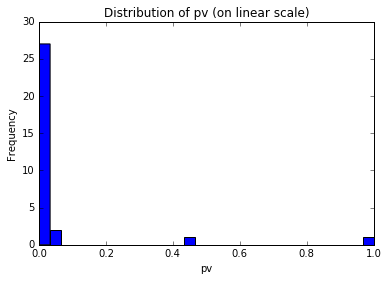

Non-negligible verification:

['hoaxy_bill-clinton-illegitimate-son_cum'
 'hoaxy_hillary-clinton-has-parkinsons-disease_cum']


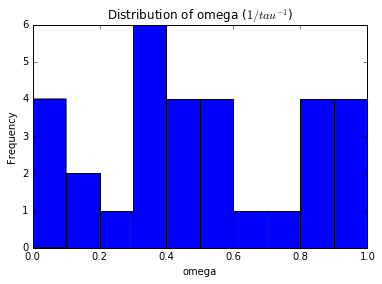

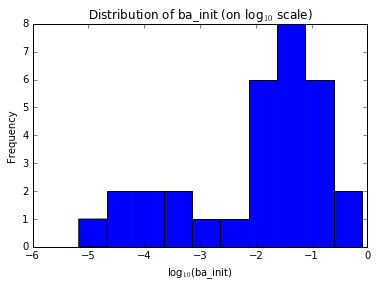

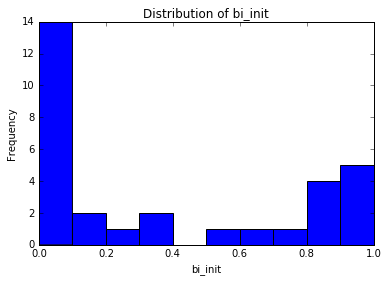

High initial fraction of inactive believers:

['hoaxy_4th-mysterious-death-connected-to-the-dnc_cum'
 'hoaxy_clinton-byrd-photo-klan_cum'
 'hoaxy_clinton-compliant-citizenry_cum'
 'hoaxy_deray-mckesson-and-the-summer-of-chaos_cum'
 'hoaxy_dr-drew-hillary-clinton-health_cum'
 'hoaxy_google-manipulate-hillary-clinton_cum'
 'hoaxy_hillary-clinton-freed-child-rapist-laughed-about-it_cum'
 'hoaxy_hillary-clinton-has-parkinsons-disease_cum'
 'hoaxy_julian-assange-bernie-sanders-was-threatened_cum'
 'hoaxy_khizr-khan-is-a-muslim-brotherhood-agent_cum'
 'hoaxy_mexico-border-trump-elected_cum' 'hoaxy_michael-savage-removed_cum']
Low initial fraction of inactive believers:

['hoaxy_alicia-machado-adult-star_cum'
 'hoaxy_bill-clinton-illegitimate-son_cum'
 'hoaxy_black-lives-matter-protesters-chant-for-dead-cops-now-in-baton-rouge_cum'
 'hoaxy_black-protesters-targeted-whites-in-milwaukee_cum'
 'hoaxy_clinton-secret-earpiece-debate_cum' 'hoaxy_clintons_zeifman_cum'
 'hoaxy_debate-secret-hand-sign

In [17]:
params_noseg = np.append(np.asarray(noseg_fit_poptFI)[:,[0,1,2,3,6,7]],np.asarray(noseg_fit_popt),axis=0).T
param_label_noseg = ["alpha", "N", "ba_init", "bi_init", "pv", "omega"]

# alpha
pp.hist(params_noseg[0],range=(0,1))
pp.title("Distribution of " + param_label_noseg[0])
pp.xlabel(param_label_noseg[0])
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/alpha.pdf")
pp.show()

print "Low belief hoaxs:\n"
print np.asarray(list_of_files)[params_noseg[0] < 0.1]

# N
pp.hist(np.log10(np.ones(len(params_noseg[1]))/params_noseg[1]))
pp.title("Distribution of " + param_label_noseg[1] + " (on log$_{10}$ scale)")
pp.xlabel("log$_{10}$(" + param_label_noseg[1] + ")")
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/N.pdf")
pp.show()

# pv
pp.hist(np.log10(params_noseg[4]),bins = 30)
pp.title("Distribution of " + param_label_noseg[4] + " (on log$_{10}$ scale)")
pp.xlabel("log$_{10}$(" + param_label_noseg[4] + ")")
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/pv_logscale.pdf")
pp.show()

pp.hist(params_noseg[4],bins = 30)
pp.title("Distribution of " + param_label_noseg[4] + " (on linear scale)")
pp.xlabel(param_label_noseg[4])
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/pv.pdf")
pp.show()

print "Non-negligible verification:\n"
print np.asarray(list_of_files)[params_noseg[4] > 0.1]

# omega
pp.hist(params_noseg[5],range=(0,1))
pp.title("Distribution of " + param_label_noseg[5] + " ($1/tau^{-1}$)")
pp.xlabel(param_label_noseg[5])
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/omega.pdf")
pp.show()

# ba_init
pp.hist(np.log10(params_noseg[2]))
pp.title("Distribution of " + param_label_noseg[2] + " (on log$_{10}$ scale)")
pp.xlabel("log$_{10}$(" + param_label_noseg[2] + ")")
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/ba_init.pdf")
pp.show()

# bi_init
pp.hist(params_noseg[3],range=(0,1))
pp.title("Distribution of " + param_label_noseg[3])
pp.xlabel(param_label_noseg[3])
pp.ylabel("Frequency")
pp.savefig("../../output/hoaxy_ALL/param_distributions/bi_init.pdf")
pp.show()

print "High initial fraction of inactive believers:\n"
print np.asarray(list_of_files)[params_noseg[3] > 0.5]

print "Low initial fraction of inactive believers:\n"
print np.asarray(list_of_files)[params_noseg[3] < 0.5]

# Fit using segregated model

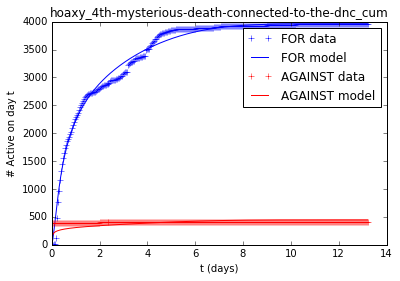

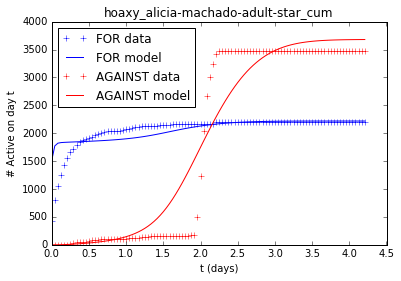

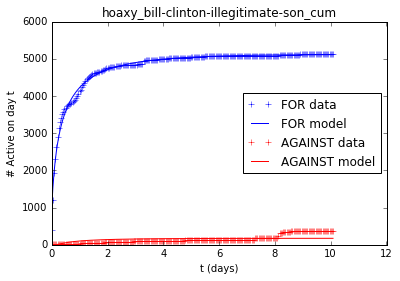

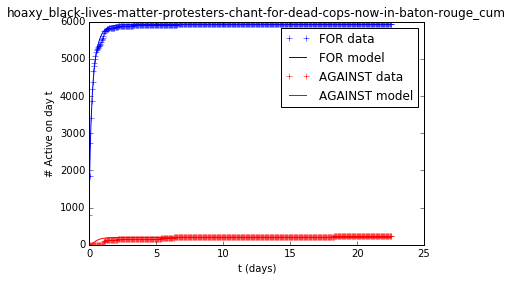

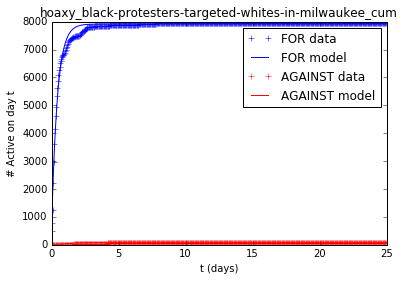

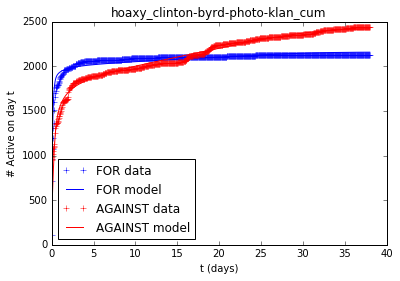

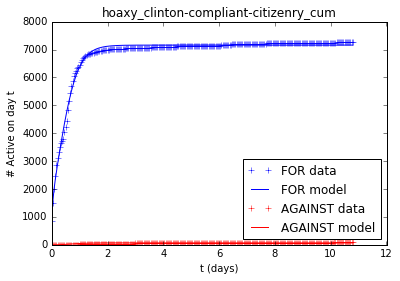

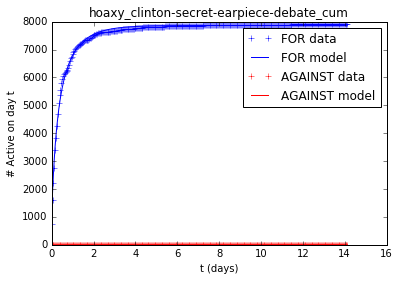

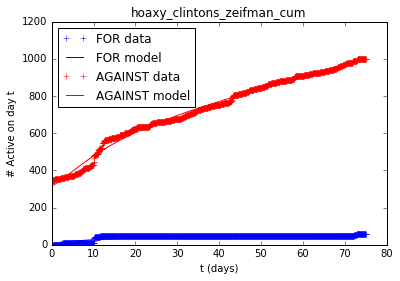

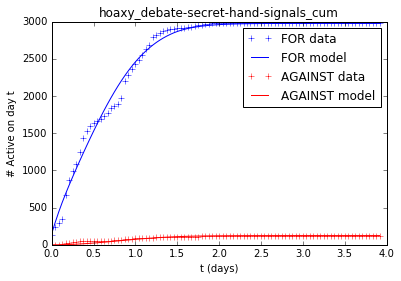

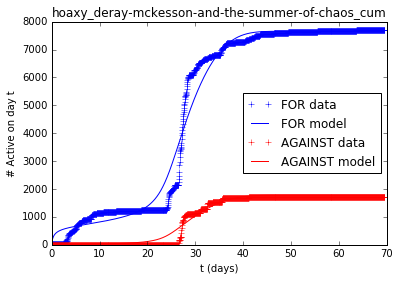

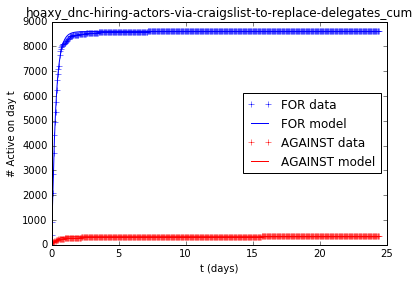

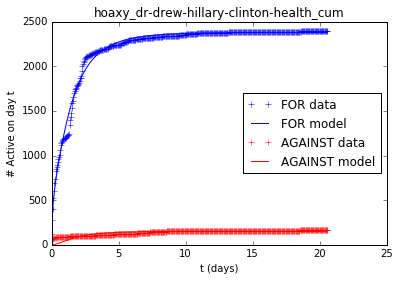

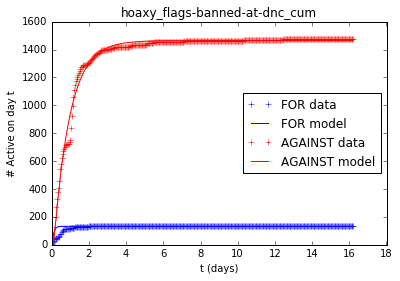

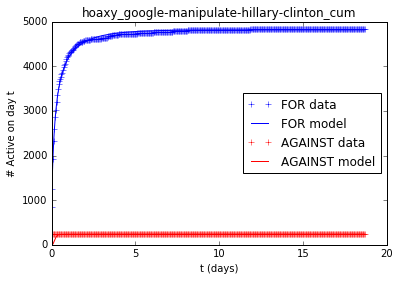

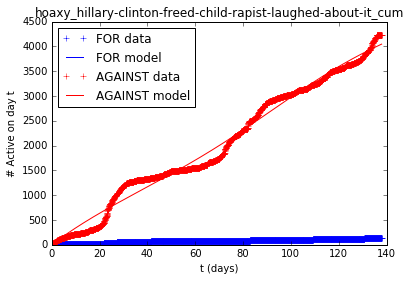

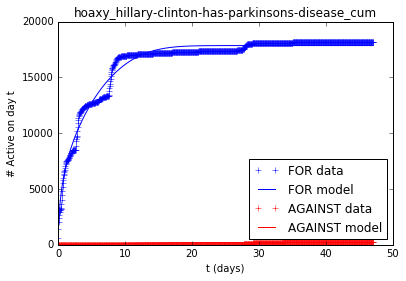

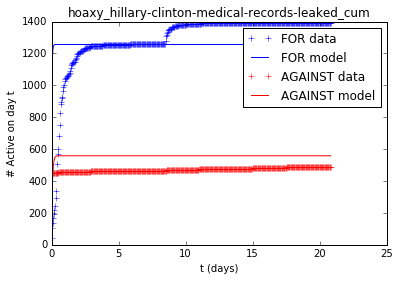

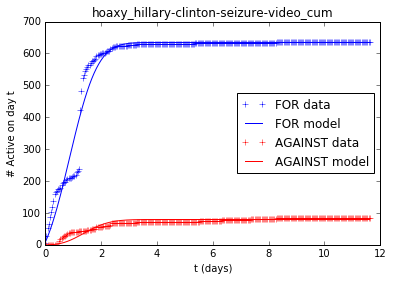

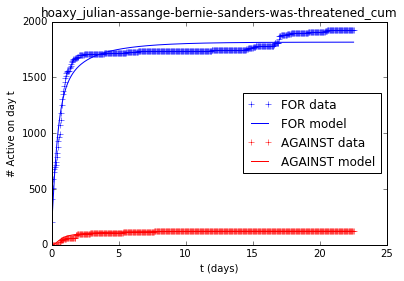

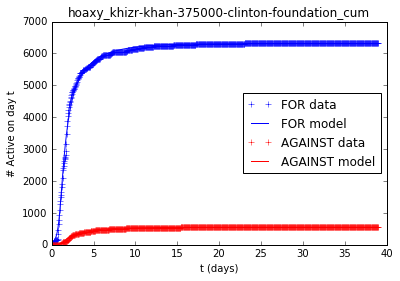

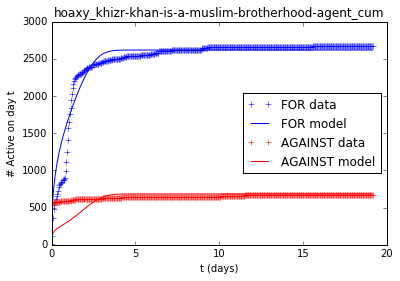

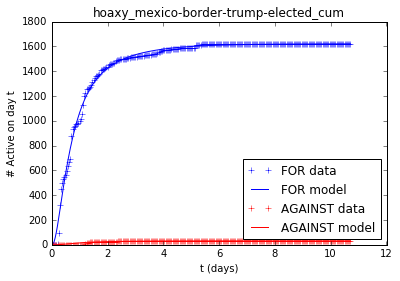

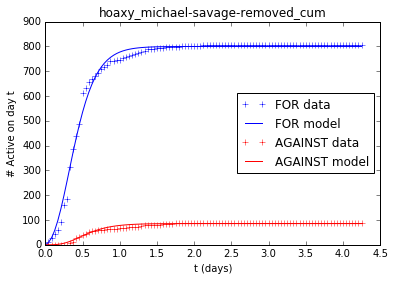

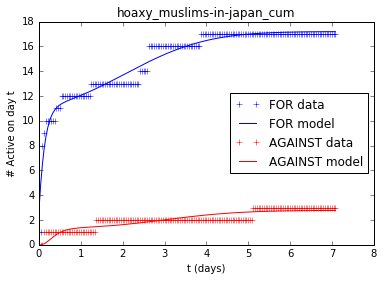

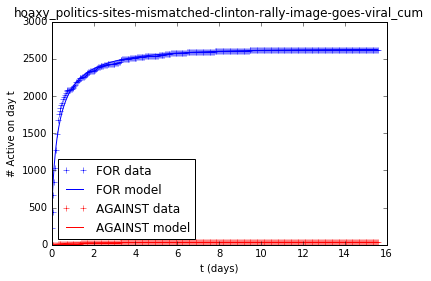

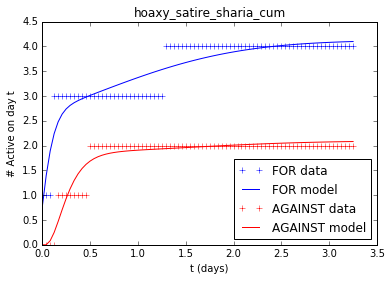

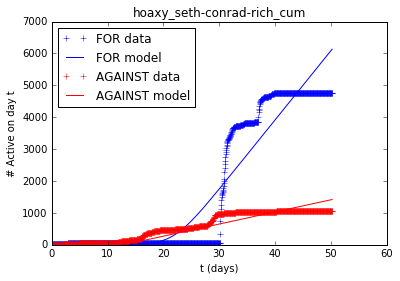

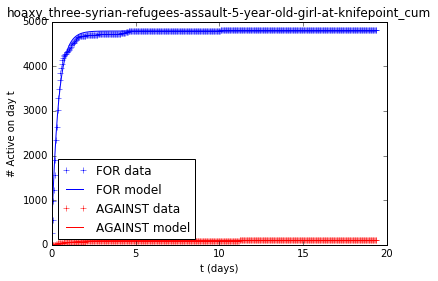

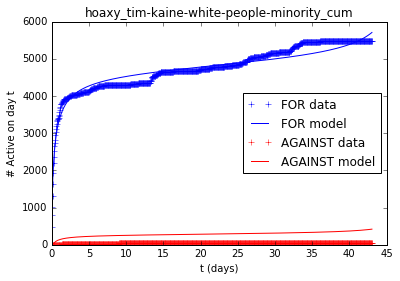

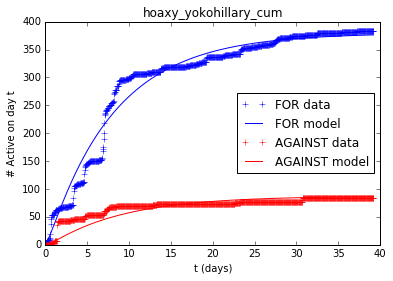

In [18]:
seg_fit_popt = [];
seg_fit_poptFI = [];
seg_fit_pcov = [];
seg_fit_pcovFI = [];
seg_fit_RMSerror = [];
seg_fit_NRMSerror = [];
seg_fit_MPerror = [];

for i in np.linspace(0,len(list_of_files)-1,len(list_of_files),dtype=int):
    
    # READ DATA

    file_name = str(list_of_files[i])
    hoax_data = pd.read_csv(path_file+file_name+'.csv',parse_dates=True)
    for_users = hoax_data["For"]
    against_users = hoax_data["Against"]
    t_empirical=np.arange(0,len(for_users))

    # FILTER DATA

    # remove the initial plateau from the data
    first_nonzero = np.nonzero(for_users)[0][0]
    for_users = for_users[first_nonzero:]
    against_users = against_users[first_nonzero:]

    # find the position of the end of the dynamics (including buffer plateau at end of length plateau_threshold)
    d_for_users = np.subtract(for_users[plateau_threshold-1:],for_users[0:-plateau_threshold+1]);
    d_against_users = np.subtract(against_users[plateau_threshold-1:],against_users[0:-plateau_threshold+1]);
    plateau = np.nonzero((np.add(d_for_users,d_against_users))==0)[0];
    if (plateau.size > 0):
        temporal_window = plateau[0] + plateau_threshold
        for_users = for_users[0:temporal_window]
        against_users = against_users[0:temporal_window]

    t_empirical=np.arange(0,len(for_users))

    # CURVEFIT AND PLOT

    if against_users.values[0] > for_users.values[0]: # If theres an initial number of factcheckers
        #params = [alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, fa_initg, fi_initg, fa_inits, fi_inits, pvg, pvs, omega, gulsize, s]
        param0 =0.5,0.5,0.0001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.5,0.5,0.5,0.5,0.5
        param_bounds =([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [1., 1., 1., 1., 1. ,1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1])

        # Curve fit
        T_double = np.append(t_empirical, t_empirical)
        data_double = np.append(for_users, against_users)
        popt, pcov = curve_fit(fit_mf_seg_FI, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)
        
        # Save measurements
        seg_fit_poptFI.append(popt)
        seg_fit_pcovFI.append(pcov)
        BA, FA = mf_seg_FI(t_empirical,*popt)
        seg_fit_RMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double)))
        seg_fit_NRMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double))/np.average(data_double))
        seg_fit_MPerror.append(np.sum(np.abs(np.append(BA,FA) - data_double)/data_double)/len(data_double))

        # Plot
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("# Active on day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/fits/"+str(i+1)+"_seg.pdf")
        pp.show()
        
    else:    
        #params = [alphag, alphas, ONEoverN, ba_initg, bi_initg, ba_inits, bi_inits, pvg, pvs, omega, gulsize, s]
        param0 =0.5,0.5,0.0001,0.001,0.001,0.001,0.001,0.5,0.5,0.5,0.5,0.5
        param_bounds =([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [1., 1., 1., 1., 1. ,1., 1., 1., 1., 1., 1., 1.])

        # Curve fit
        T_double = np.append(t_empirical, t_empirical)
        data_double = np.append(for_users, against_users)
        popt, cov = curve_fit(fit_mf_seg, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)

   
        # Save measurements
        seg_fit_popt.append(popt)
        seg_fit_pcov.append(pcov)
        BA, FA = mf_seg(t_empirical,*popt)
        seg_fit_RMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double)))
        seg_fit_NRMSerror.append(np.sqrt(np.sum(np.square(np.append(BA,FA) - data_double))/len(data_double))/np.average(data_double))
        seg_fit_MPerror.append(np.sum(np.abs(np.append(BA,FA) - data_double)/data_double)/len(data_double))

        # Plot
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("# Active on day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/fits/"+str(i+1)+"_seg.pdf")
        pp.show()

    

In [205]:
# Save outputs
f = open("../../data/processed/outputs_seg.pckl","wb")
pickle.dump([seg_fit_popt,seg_fit_poptFI,seg_fit_pcov,seg_fit_pcovFI,seg_fit_RMSerror,seg_fit_NRMSerror,seg_fit_MPerror], f)
f.close()

### Comparison of errors

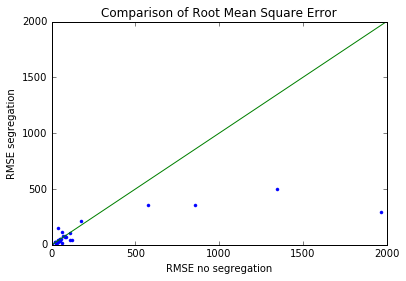

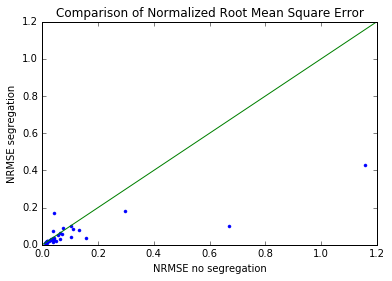

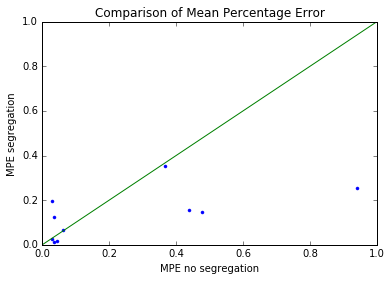

In [19]:
pp.figure()
pp.plot(noseg_fit_RMSerror,seg_fit_RMSerror,".",np.linspace(0,2000),np.linspace(0,2000))
pp.xlabel("RMSE no segregation")
pp.ylabel("RMSE segregation")
pp.title("Comparison of Root Mean Square Error")
pp.savefig("../../output/hoaxy_ALL/errors/RMSEcomparison.pdf")
pp.show()

pp.figure()
pp.plot(noseg_fit_NRMSerror,seg_fit_NRMSerror,".",np.linspace(0,1.2),np.linspace(0,1.2))
pp.xlabel("NRMSE no segregation")
pp.ylabel("NRMSE segregation")
pp.title("Comparison of Normalized Root Mean Square Error")
pp.savefig("../../output/hoaxy_ALL/errors/NRMSEcomparison.pdf")
pp.show()

pp.figure()
pp.plot(noseg_fit_MPerror,seg_fit_MPerror,".",np.linspace(0,1),np.linspace(0,1))
pp.xlabel("MPE no segregation")
pp.ylabel("MPE segregation")
pp.title("Comparison of Mean Percentage Error")
pp.savefig("../../output/hoaxy_ALL/errors/MPEcomparison.pdf")
pp.show()

In [264]:

print np.nonzero([x > 500 for x in noseg_fit_RMSerror])[0]
print np.nonzero([x > 0.2 for x in noseg_fit_NRMSerror])[0]
print np.asarray(list_of_files)[[1,10,16,27]]

[ 1 10 16 27]
[ 1 10 27]
['hoaxy_alicia-machado-adult-star_cum'
 'hoaxy_deray-mckesson-and-the-summer-of-chaos_cum'
 'hoaxy_hillary-clinton-has-parkinsons-disease_cum'
 'hoaxy_seth-conrad-rich_cum']


# Fit using only For data

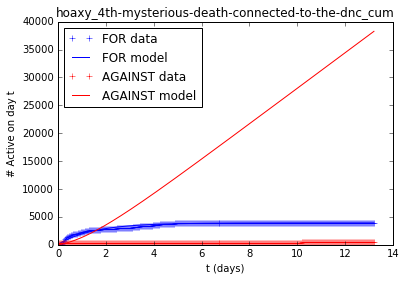

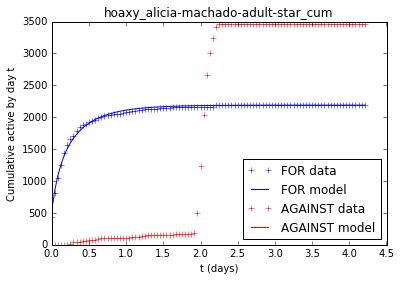

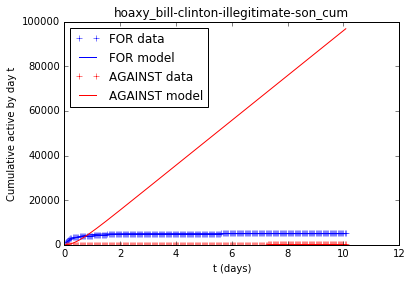

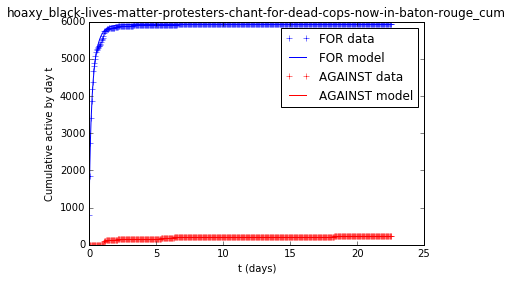

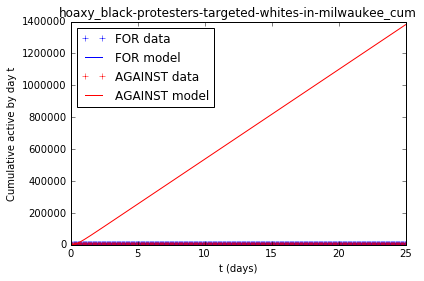

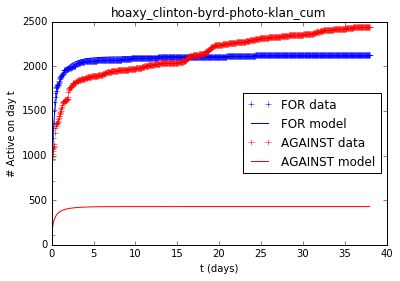

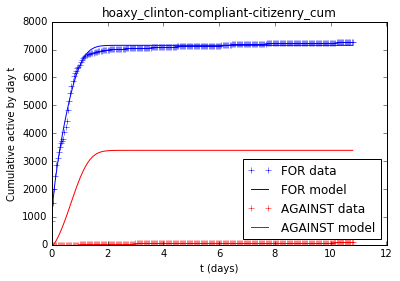

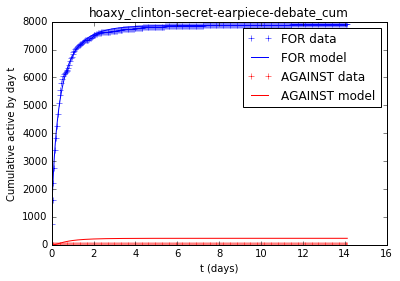

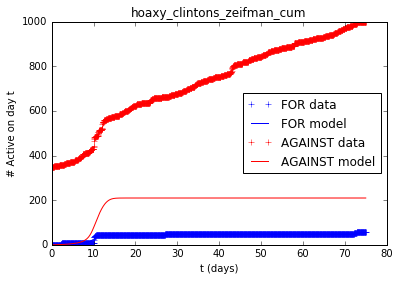

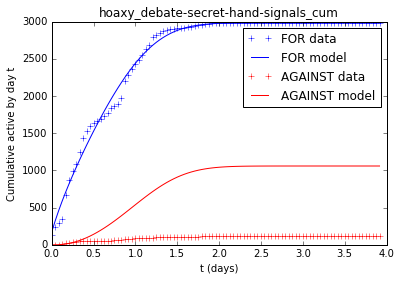

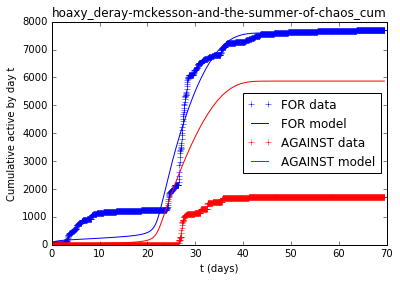

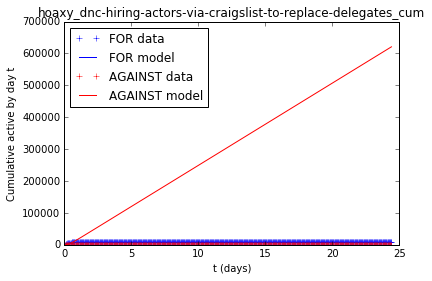

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [121]:
for i in np.linspace(0,len(list_of_files)-1,len(list_of_files),dtype=int):

    # READ DATA

    file_name = str(list_of_files[i])
    hoax_data = pd.read_csv(path_file+file_name+'.csv',parse_dates=True)
    for_users = hoax_data["For"]
    against_users = hoax_data["Against"]
    t_empirical=np.arange(0,len(for_users))

    # FILTER DATA

    # remove the initial plateau from the data
    first_nonzero = np.nonzero(for_users)[0][0]
    for_users = for_users[first_nonzero:]
    against_users = against_users[first_nonzero:]

    # find the position of the end of the dynamics (including buffer plateau at end of length plateau_threshold)
    d_for_users = np.subtract(for_users[plateau_threshold-1:],for_users[0:-plateau_threshold+1]);
    d_against_users = np.subtract(against_users[plateau_threshold-1:],against_users[0:-plateau_threshold+1]);
    plateau = np.nonzero((np.add(d_for_users,d_against_users))==0)[0];
    if (plateau.size > 0):
        temporal_window = plateau[0] + plateau_threshold
        for_users = for_users[0:temporal_window]
        against_users = against_users[0:temporal_window]

    t_empirical=np.arange(0,len(for_users))

    # CURVEFIT AND PLOT

    if against_users.values[0] > for_users.values[0]:
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001,0.001,0.001, 0.001, 0.5,0.5
        param_bounds =([0., 0., 0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1., 1., 1.])

        # Curve fit
        popt, cov = curve_fit(mf_noseg_FI_BA, t_empirical, for_users, p0=param0,bounds=param_bounds, max_nfev=100000)

        # Plot
        BA, FA = mf_noseg_FI(t_empirical,*popt)
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("# Active on day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/00_fit_using_for/"+str(i+1)+"_noseg.pdf")
        pp.show()

    else:
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001, 0.001, 0.5,0.5
        param_bounds =([0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1.])

        # Curve fit
        popt, cov = curve_fit(mf_noseg_BA, t_empirical, for_users, p0=param0,bounds=param_bounds, max_nfev=100000)

        # Plot
        BA, FA = mf_noseg(t_empirical,*popt)
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("Cumulative active by day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/00_fit_using_for/"+str(i+1)+"_noseg.pdf")
        pp.show()
    

# Fit using non-segregated model and 1 day data

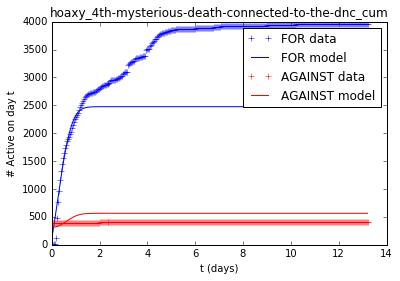

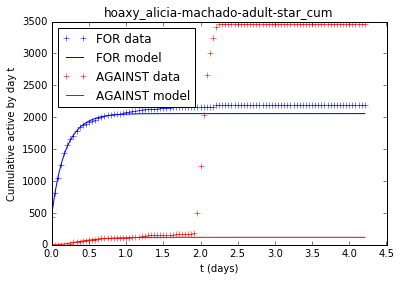

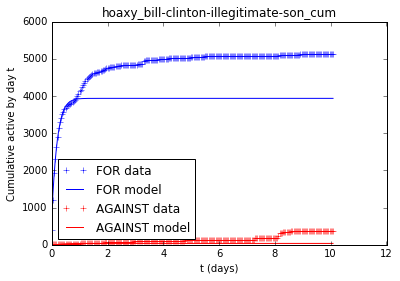

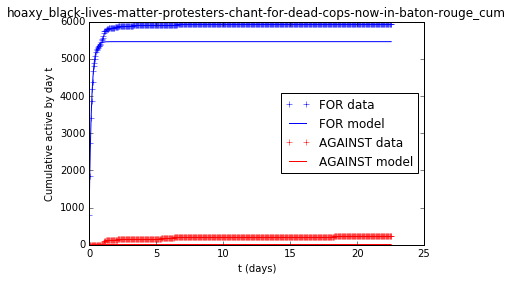

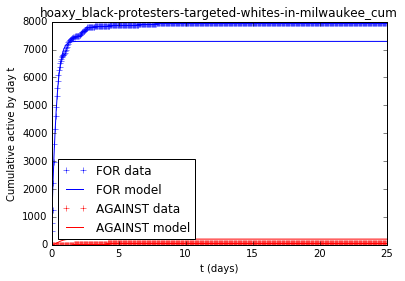

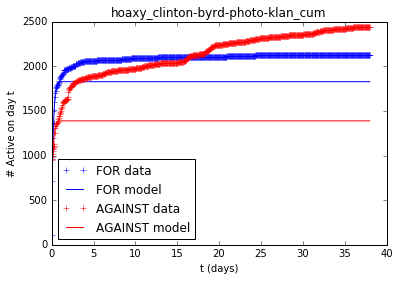

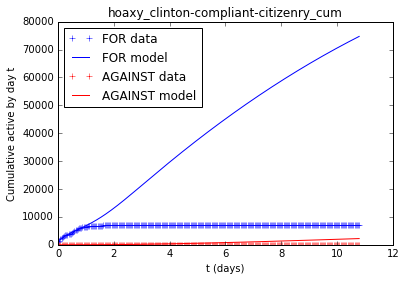

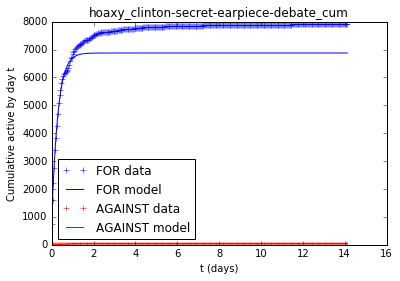

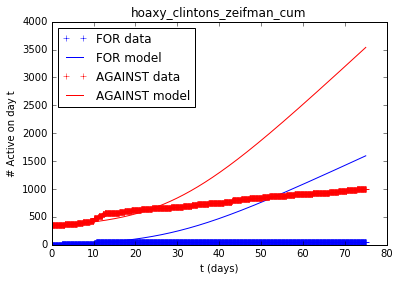

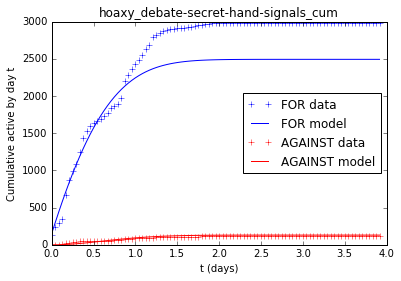

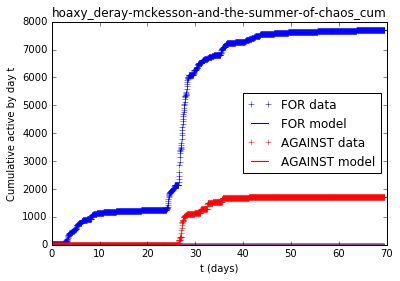

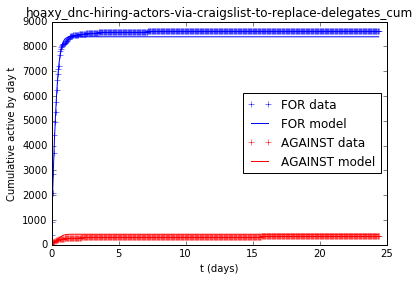

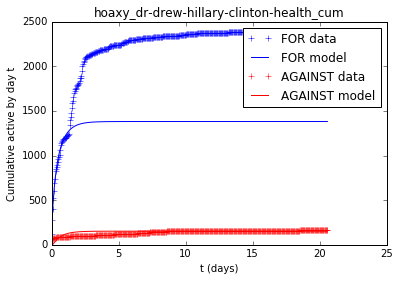

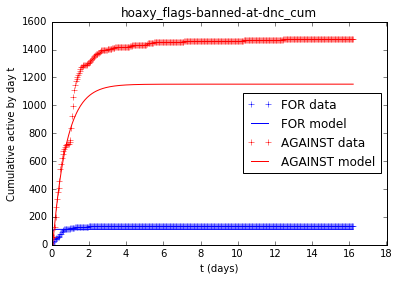

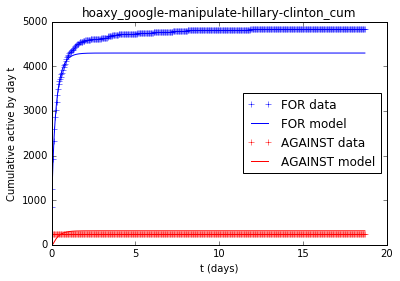

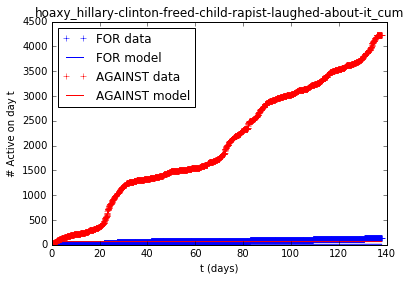

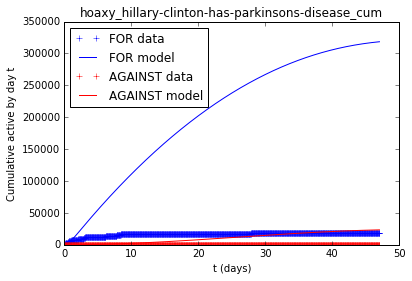

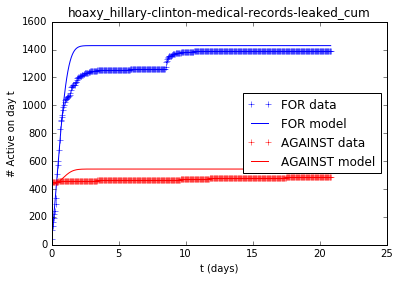

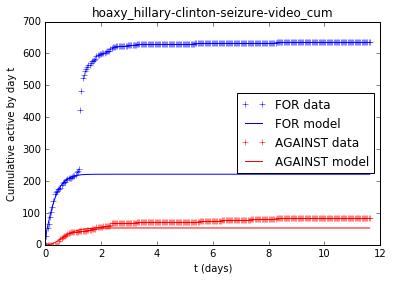

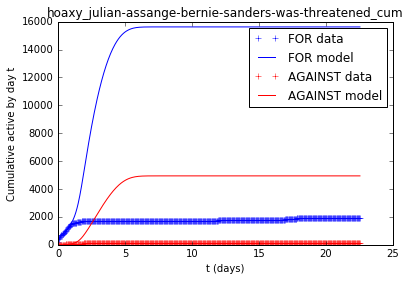

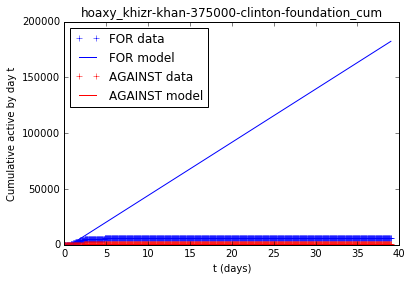

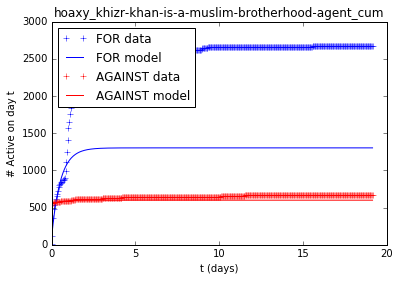

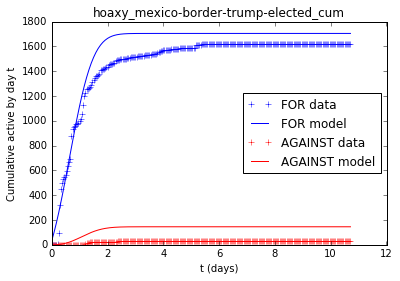

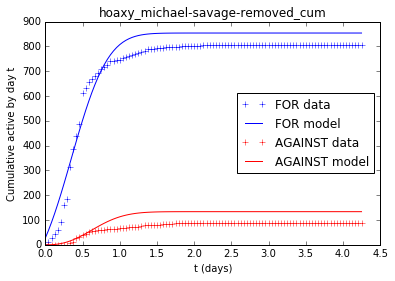

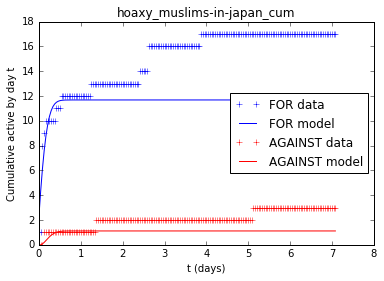

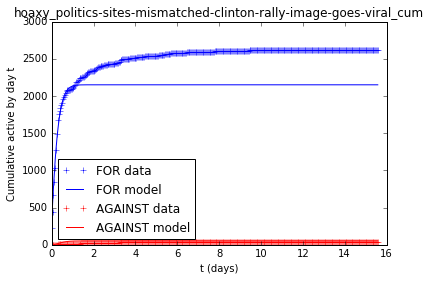

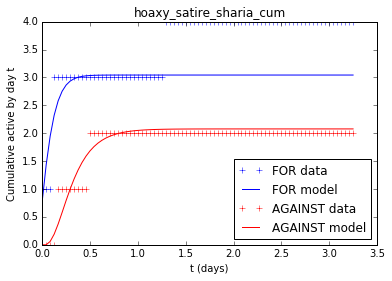

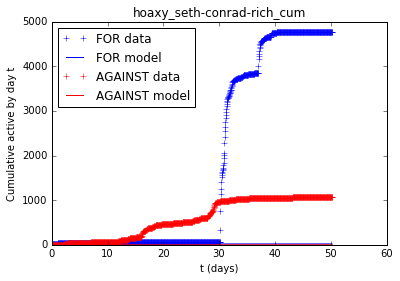

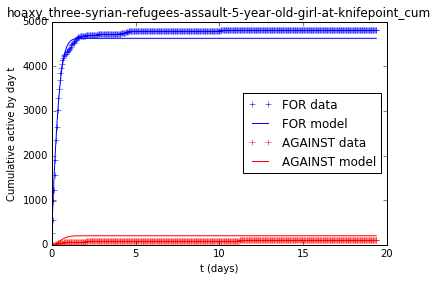

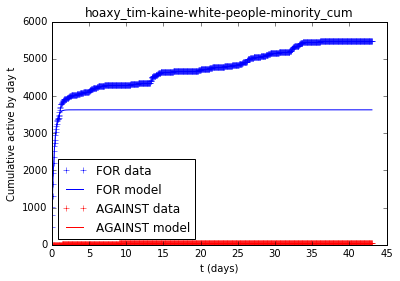

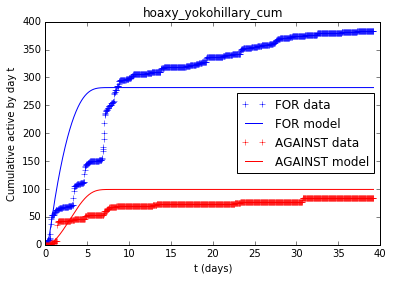

In [122]:
fit_T = 24 # 24 hours

for i in np.linspace(0,len(list_of_files)-1,len(list_of_files),dtype=int):

    # READ DATA

    file_name = str(list_of_files[i])
    hoax_data = pd.read_csv(path_file+file_name+'.csv',parse_dates=True)
    for_users = hoax_data["For"]
    against_users = hoax_data["Against"]
    t_empirical=np.arange(0,len(for_users))

    # FILTER DATA

    # remove the initial plateau from the data
    first_nonzero = np.nonzero(for_users)[0][0]
    for_users = for_users[first_nonzero:]
    against_users = against_users[first_nonzero:]

    # find the position of the end of the dynamics (including buffer plateau at end of length plateau_threshold)
    d_for_users = np.subtract(for_users[plateau_threshold-1:],for_users[0:-plateau_threshold+1]);
    d_against_users = np.subtract(against_users[plateau_threshold-1:],against_users[0:-plateau_threshold+1]);
    plateau = np.nonzero((np.add(d_for_users,d_against_users))==0)[0];
    if (plateau.size > 0):
        temporal_window = plateau[0] + plateau_threshold
        for_users = for_users[0:temporal_window]
        against_users = against_users[0:temporal_window]

    t_empirical=np.arange(0,len(for_users))

    # CURVEFIT AND PLOT

    if against_users.values[0] > for_users.values[0]:
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001,0.001,0.001, 0.001, 0.5,0.5
        param_bounds =([0., 0., 0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1., 1., 1.])

        # Curve fit
        T_double = np.append(t_empirical[0:fit_T], t_empirical[0:fit_T])
        data_double = np.append(for_users[0:fit_T], against_users[0:fit_T])
        popt, cov = curve_fit(fit_mf_noseg_FI, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)

        # Plot
        BA, FA = mf_noseg_FI(t_empirical,*popt)
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("# Active on day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/"+str(i+1)+"_noseg_1dayfit.pdf")
        pp.show()

    else:
        #params = [alpha, ONEoverN, ba_init, bi_init, fa_init, fi_init, pv, omega]
        param0 =0.5,0.0001,0.001, 0.001, 0.5,0.5
        param_bounds =([0, 0., 0., 0., 0., 0.], [1., 1., 1., 1., 1. ,1.])

        # Curve fit
        T_double = np.append(t_empirical[0:fit_T], t_empirical[0:fit_T])
        data_double = np.append(for_users[0:fit_T], against_users[0:fit_T])
        popt, cov = curve_fit(fit_mf_noseg, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=10000)

        # Plot
        BA, FA = mf_noseg(t_empirical,*popt)
        pp.figure()
        pp.plot(t_empirical/24., for_users, 'b+',t_empirical/24., 
            BA,'b-', t_empirical/24., against_users, 'r+',t_empirical/24., 
            FA,'r-')
        pp.xlabel("t (days)")
        pp.ylabel("Cumulative active by day t")
        pp.title(file_name)
        pp.legend(['FOR data', 'FOR model','AGAINST data', 'AGAINST model'],loc=0)
        pp.savefig("../../output/hoaxy_ALL/"+str(i+1)+"_noseg_1dayfit.pdf")
        pp.show()
    